In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [5]:
# Load the data
X_train = pd.read_csv('X_train.csv')
test_df = pd.read_csv('X_test.csv')

# Step 1: Filter out post-collision data
collision_filter = (X_train['x_1'] == 0) & (X_train['y_1'] == 0) & (X_train['x_2'] == 0) & (X_train['y_2'] == 0) & (X_train['x_3'] == 0) & (X_train['y_3'] == 0)
X_train_filtered = X_train[~collision_filter]

# Step 2: Identify unique initial positions
initial_conditions = X_train_filtered[X_train_filtered['t'] == 0].copy()


# Select only the initial conditions (assuming only the first row of each unique 'Id' is needed)
initial_conditions_test = test_df[test_df['t'] == 0].copy()


# Create a unique identifier based on rounded initial positions
initial_conditions['trajectory_id'] = (
    initial_conditions['x_1'].round(6).astype(str) + '_' +
    initial_conditions['y_1'].round(6).astype(str) + '_' +
    initial_conditions['x_2'].round(6).astype(str) + '_' +
    initial_conditions['y_2'].round(6).astype(str) + '_' +
    initial_conditions['x_3'].round(6).astype(str) + '_' +
    initial_conditions['y_3'].round(6).astype(str)
).astype('category').cat.codes

# Map this identifier back to the main dataframe based on match at t=0
X_train_filtered = X_train_filtered.merge(initial_conditions[['trajectory_id', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']],
                                          on=['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'],
                                          how='left')

# Fill missing trajectory_ids for the rest of the times using forward fill
X_train_filtered['trajectory_id'] = X_train_filtered['trajectory_id'].ffill()

# Count the occurrences of each trajectory code
trajectory_counts = X_train_filtered['trajectory_id'].value_counts()

In [6]:
#Split train-test-valid

# Step 1: Extract the unique trajectory IDs
unique_trajectories = X_train_filtered['trajectory_id'].unique()

# Step 2: Use train_test_split to split these trajectory IDs
train_ids, test_ids = train_test_split(unique_trajectories, test_size=0.2, random_state=42)

# Step 3: Now split the dataset by filtering for these trajectory IDs
train_data = X_train_filtered[X_train_filtered['trajectory_id'].isin(train_ids)]
test_data = X_train_filtered[X_train_filtered['trajectory_id'].isin(test_ids)]


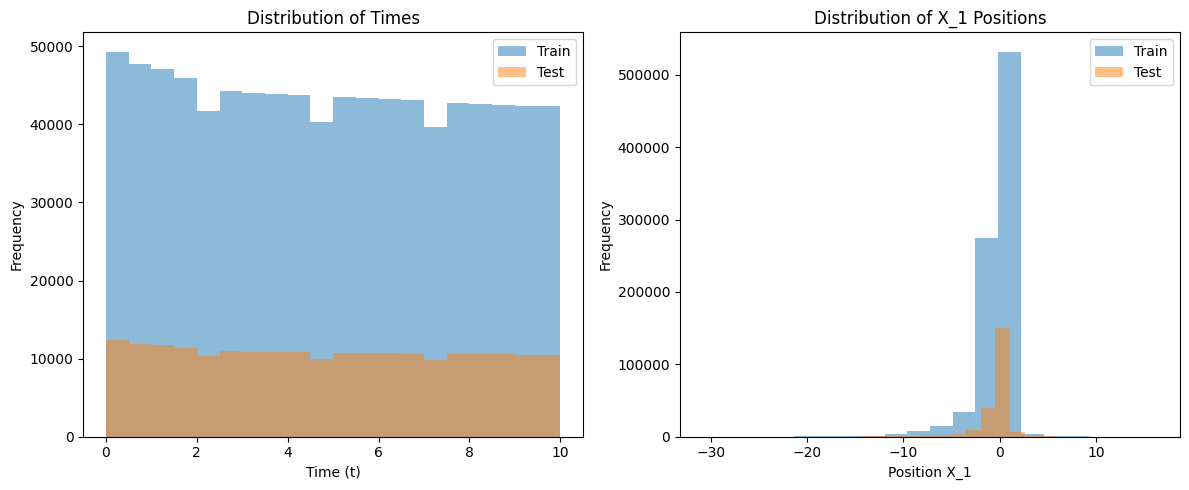

No overlap in trajectory IDs between train and test sets.


In [8]:
import matplotlib.pyplot as plt

# Check the distribution of key features across splits
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_data['t'], bins=20, alpha=0.5, label='Train')
plt.hist(test_data['t'], bins=20, alpha=0.5, label='Test')
plt.title('Distribution of Times')
plt.xlabel('Time (t)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(train_data['x_1'], bins=20, alpha=0.5, label='Train')
plt.hist(test_data['x_1'], bins=20, alpha=0.5, label='Test')
plt.title('Distribution of X_1 Positions')
plt.xlabel('Position X_1')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Ensure no overlap in trajectory IDs between train and test sets
train_ids_set = set(train_data['trajectory_id'])
test_ids_set = set(test_data['trajectory_id'])

assert len(train_ids_set.intersection(test_ids_set)) == 0, "There is overlap in trajectory IDs between train and test sets."

# Checking for overlap between train and test trajectory IDs
if len(train_ids_set.intersection(test_ids_set)) > 0:
    print("There is overlap in trajectory IDs between train and test sets.")
    overlapping_ids = train_ids_set.intersection(test_ids_set)
    print("Overlapping IDs:", overlapping_ids)
else:
    print("No overlap in trajectory IDs between train and test sets.")



In [ ]:
# Define feature and target columns 
feature_columns = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_columns = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

#X_test_features = test_df[['t', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']]

# Prepare the test features from X_test.csv
#X_test_features = test_df[['t', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']]
#X_test_features = X_test_features.rename(columns={'x0_1': 'x_1', 'y0_1': 'y_1', 'x0_2': 'x_2', 'y0_2': 'y_2', 'x0_3': 'x_3', 'y0_3': 'y_3'})

# Create the pipeline with StandardScaler and LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])



# Initialize the model
pipeline.fit(train_data[feature_columns], train_data[target_columns])

# Predict the test data
predictions = pipeline.predict(test_data[feature_columns])

print("predictions", predictions)

#evaluate the model
mse = mean_squared_error(test_data[target_columns], predictions)
print(f'Mean Squared Error: {mse}')

In [ ]:
# Prepare the submission file
submission_df = pd.DataFrame(y_test_pred, columns=target_columns)
submission_df.insert(0, 'Id', test_df['Id'])
submission_df.to_csv('baseline-model.csv', index=False)
print("Submission file 'submission_file.csv' created.")

In [ ]:
def plot_y_yhat(y_test, y_pred, plot_title="plot"):
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test), MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10, 10))
    for i in range(6):
        x0 = np.min(y_test[idx, i])
        x1 = np.max(y_test[idx, i])
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test[idx, i], y_pred[idx, i])
        plt.xlabel('True ' + labels[i])
        plt.ylabel('Predicted ' + labels[i])
        plt.plot([x0, x1], [x0, x1], color='red')  # Identity line
        plt.axis('square')
    plt.savefig(plot_title + '.pdf')
    plt.show()


# Assuming y_val_targets and y_val_pred are your validation actuals and predictions
# Convert DataFrame to numpy array if not already
y_test_array = y_val_targets.to_numpy()
y_pred_array = y_val_pred

# Call the plotting function
plot_y_yhat(y_test_array, y_pred_array, "Validation Performance")